In [2]:


import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.patheffects as path_effects
import matplotlib.font_manager as fm
import matplotlib.colors as mcolors
from matplotlib import cm
from highlight_text import fig_text, ax_text
from matplotlib.patches import RegularPolygon

# We'll only use a vertical pitch for this tutorial
from mplsoccer import VerticalPitch

from PIL import Image
import urllib
import os




data = pd.read_csv('tabelaCarioca/10172022.csv', index_col=0)


data = data[data['situation'] != 'Penalty'].reset_index(drop=True)
data

,teamId,playerId,playerName,min,xG,eventType,teamColor,match_id,isOwnGoal,x,y,situation,teamName
0,6578,954092,Everton Cebolinha,4,0.57,Goal,#003070,3888456,False,97.377193,39.208810,RegularPlay,Flamengo
1,6578,954092,Everton Cebolinha,4,0.57,Missed,#003070,3888456,False,97.377193,39.208810,RegularPlay,Flamengo
2,6578,389892,Manuel Capasso,9,0.54,Goal,#003070,3888456,False,97.184213,31.636251,RegularPlay,Vasco
3,6578,389892,Manuel Capasso,9,0.54,Missed,#003070,3888456,False,97.184213,31.636251,RegularPlay,Vasco
4,8561,254308,Jeffinho,10,0.85,Goal,#005098,3888456,False,91.199997,30.292000,RegularPlay,Botafogo
5,8561,254308,Jeffinho,10,0.85,Missed,#005098,3888456,False,91.199997,30.292000,RegularPlay,Botafogo
6,8561,915602,Lelê,13,0.37,Goal,#005098,3888456,False,81.583977,29.799763,RegularPlay,Fluminense
7,8561,915602,Lelê,13,0.37,Missed,#005098,3888456,False,81.583977,29.799763,RegularPlay,Fluminense
8,8561,915602,Lelê,13,0.37,missed,#005098,3888456,False,81.583977,29.799763,RegularPlay,Fluminense


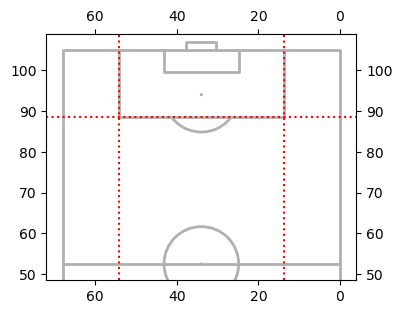

In [3]:


fig = plt.figure(figsize = (4,4), dpi = 100)
ax = plt.subplot(111)
pitch = VerticalPitch(
    pitch_type='uefa',
    half=True,
    axis=True, 
    label=True, 
    tick=True,
    goal_type='box'
)
pitch.draw(ax = ax)

ax.plot([13.84, 13.84], [ax.get_ylim()[0], ax.get_ylim()[1]], ls=':', color='red')
ax.plot([54.16, 54.16], [ax.get_ylim()[0], ax.get_ylim()[1]], ls=':', color='red')

ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [88.5,88.5], ls=':', color='red')



In [4]:


def is_inside_box(x,y):
    '''
    Checks if a shot lies within the dimensions of our box.
    '''
    if (x >= 13.84) & (x <= 54.16) & (y >=88.5):
        return True
    else:
        return False

# We invert the data because we're looking at a Vertical Pitch
data['is_in_box'] = [is_inside_box(x,y) for x,y in zip(data['y'], data['x'])]
data_groupped = data.groupby(['playerId', 'playerName', 'teamId', 'is_in_box'])['min'].count().reset_index()

data_groupped = data_groupped.pivot(columns='is_in_box', index=['playerId', 'playerName', 'teamId'], values='min').reset_index()
data_groupped.columns = ['playerId', 'playerName', 'teamId', 'False', 'True']
data_groupped.fillna(0, inplace=True)

data_groupped['total'] = data_groupped['False'] + data_groupped['True']
data_groupped['share'] = data_groupped['True']/data_groupped['total']

data_groupped = (
    data_groupped
    .sort_values(by='total', ascending=False)
    .head(6)
)
data_groupped



,playerId,playerName,teamId,False,True,total,share
2,915602,Lelê,8561,3.0,0.0,3.0,0.0
0,254308,Jeffinho,8561,0.0,2.0,2.0,1.0
1,389892,Manuel Capasso,6578,0.0,2.0,2.0,1.0
3,954092,Everton Cebolinha,6578,0.0,2.0,2.0,1.0


In [5]:
data = data[data['playerId'].isin(data_groupped['playerId'])].reset_index(drop=True)

In [6]:
colors = [
    '#d0d6d4',
    '#c5d0cd',
    '#bbcac7',
    '#b0c3c1',
    '#a6bdbb',
    '#9bb7b5',
    '#91b1af',
    '#86aaa8',
    '#7ca4a2',
    '#719e9c',
    '#679896',
    '#5c9190',
    '#528b8a',
    '#478583',
    '#3d7f7d',
    '#327877',
    '#287271',
]
soc_cm = mcolors.LinearSegmentedColormap.from_list('SOC', colors, N=50)
cm.register_cmap(name='SOC', cmap=soc_cm)

C:\Users\Letic\AppData\Local\Temp\ipykernel_17800\2033520500.py:21: MatplotlibDeprecationWarning: The register_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps.register(name)`` instead.
  cm.register_cmap(name='SOC', cmap=soc_cm)


FileNotFoundError: [Errno 2] No such file or directory: 'figures/10172022_epl_shots_4quads.png'

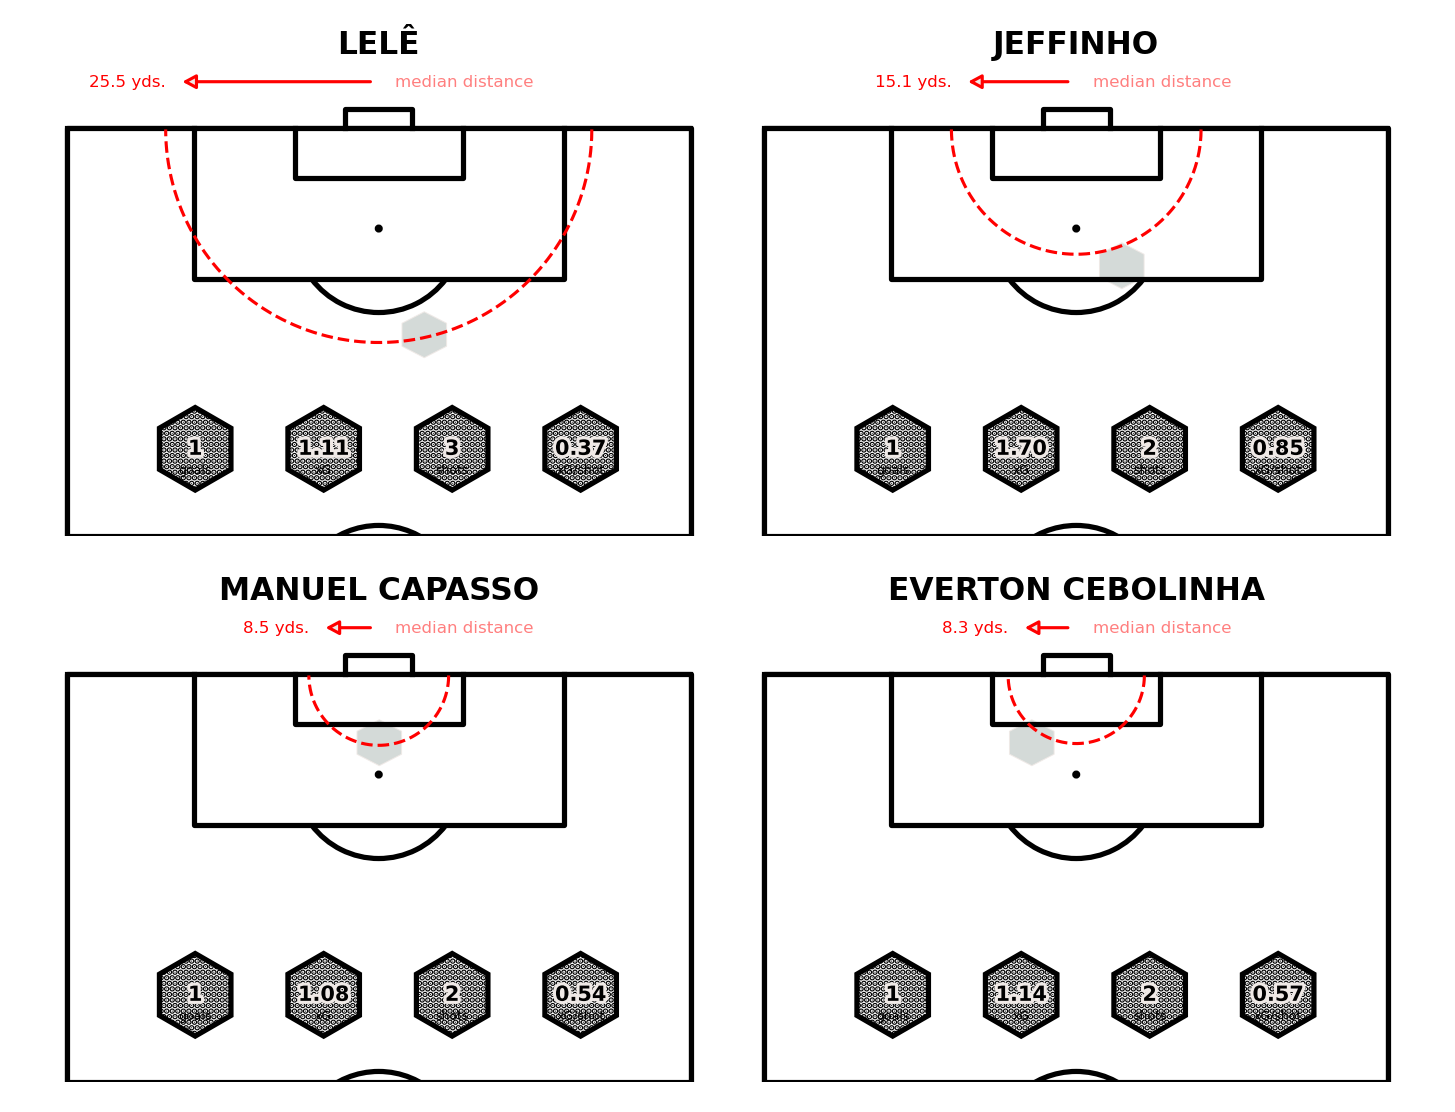

In [8]:
import numpy as np
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from adjustText import adjust_text
from matplotlib.patches import RegularPolygon
from mplsoccer.pitch import VerticalPitch
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.patheffects import withStroke
from matplotlib.font_manager import FontProperties
from matplotlib import patheffects
from PIL import Image
import urllib.request

# Function for semicircle
def semicircle(r, h, k):
    x0 = h - r  # determine x start
    x1 = h + r  # determine x finish
    x = np.linspace(x0, x1, 10000)  # many points to solve for y

    # use numpy for array solving of the semicircle equation
    y = k - np.sqrt(r**2 - (x - h)**2)  
    return x, y

def plot_hexbin_shot(ax, playerId):
    pitch = VerticalPitch(
        pitch_type='uefa',
        half=True,
        goal_type='box',
        linewidth=1.25,
        line_color='black',
        pad_bottom=-8,
        pad_top=10
    )
    pitch.draw(ax=ax)

    aux_data = data[data['playerId'] == playerId]
    bins = pitch.hexbin(x=aux_data['x'], y=aux_data['y'], ax=ax, cmap='SOC', gridsize=(14, 14), zorder=-1, edgecolors='#efe9e6', alpha=0.9, lw=.25)

    x_circle, y_circle = semicircle(104.8 - aux_data['x'].median(), 34, 104.8)  # function call
    ax.plot(x_circle, y_circle, ls='--', color='red', lw=.75)

    annot_x = [54 - x*14 for x in range(0, 4)] 
    annot_texts = ['goals', 'xG', 'shots', 'xG/shot']
    annot_stats = [aux_data[aux_data['eventType'] == 'Goal'].shape[0], aux_data['xG'].sum(), aux_data.shape[0], aux_data['xG'].sum()/aux_data.shape[0]]
    for x, s, stat in zip(annot_x, annot_texts, annot_stats):
        hex_annotation = RegularPolygon((x, 70), numVertices=6, radius=4.5, edgecolor='black', fc='None', hatch='.........', lw=1.25)
        ax.add_patch(hex_annotation)
        ax.annotate(
            xy=(x, 70),
            text=s,
            xytext=(0, -5),
            textcoords='offset points',
            size=3,
            ha='center',
            va='center'
        )
        if isinstance(stat, int):
            text_stat = f'{stat:.0f}'
        else:
            text_stat = f'{stat:.2f}'
        text_ = ax.annotate(
            xy=(x, 70),
            text=text_stat,
            xytext=(0, 0),
            textcoords='offset points',
            size=5,
            ha='center',
            va='center',
            weight='bold'
        )
        text_.set_path_effects(
            [path_effects.Stroke(linewidth=1.5, foreground='#efe9e6'), path_effects.Normal()]
        )

    # Draw the annotations at the top of the box
    median_annotation = ax.annotate(
        xy=(34, 110),
        xytext=(x_circle[-1], 110),
        text=f"{((105 - aux_data['x'].median()) * 18) / 16.5 * 0.9144:.1f} m.",
        size=4,
        color='red',
        ha='right',
        va='center',
        arrowprops=dict(arrowstyle= '<|-, head_width=0.35, head_length=0.65',
            color='red',
            fc='#efe9e6',
            lw=0.75)
    )

    ax.annotate(
        xy=(34, 110),
        xytext=(4, 0),
        text=f"median distance",
        textcoords='offset points',
        size=4,
        color='red',
        ha='left',
        va='center',
        alpha=0.5
    )

    ax.annotate(
        xy=(34, 114),
        text=f"{aux_data['playerName'].iloc[0].upper()}",
        size=7.5,
        color='black',
        ha='center',
        va='center',
        weight='bold'
    )

    return ax

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(6, 6), dpi=300)  # Adjust the figsize here
axs = np.array(axs)

# Loop through the top 4 players
for index, ax in enumerate(axs.reshape(-1)[:4]):
    plot_hexbin_shot(ax, data_groupped['playerId'].iloc[index])

plt.subplots_adjust(wspace=0, hspace=-.35)

'''# Add main title and credits
fig_text(
    x=0.5, y=.95,
    s="Carioca Championship - Round 1 - 2024",
    va="bottom", ha="center",
    fontsize=18, color="black", font="Nippo", weight="bold"
)'''

plt.savefig(
    "figures/10172022_epl_shots_4quads.png",
    dpi=600,
    facecolor="#EFE9E6",
    bbox_inches="tight",
    edgecolor="none",
    transparent=False
)

plt.savefig(
    "figures/10172022_epl_shots_4quads_tr.png",
    dpi=600,
    facecolor="none",
    bbox_inches="tight",
    edgecolor="none",
    transparent=True
)

plt.show()
